### Build 3 different types to predict stock prices

In [3]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from time import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df = pd.read_csv('TSLA.csv')

In [5]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d') # Converts string to datetime
df = df.set_index('Date') # Set the index of dataframe to date column

In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-09-07,20.610001,21.000000,20.500000,20.540001,20.540001,243400
2010-09-08,20.660000,20.950001,20.600000,20.900000,20.900000,288400
2010-09-09,21.000000,21.049999,20.690001,20.709999,20.709999,376200
2010-09-10,20.750000,20.930000,19.760000,20.170000,20.170000,386600
2010-09-13,20.889999,20.900000,20.500000,20.719999,20.719999,360800


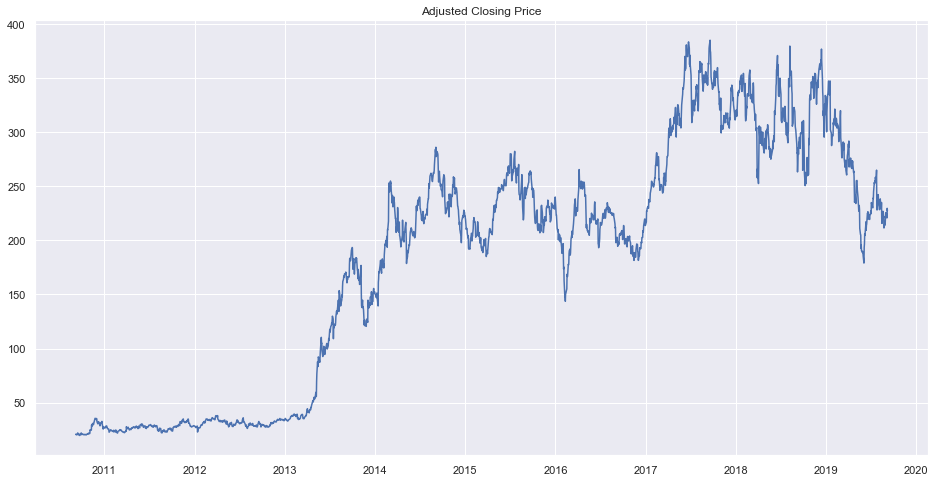

In [12]:
#Ploting
fig = plt.figure(figsize = (16,8))
plt.plot(df['Adj Close'])
plt.title('Adjusted Closing Price')
plt.show()

In [13]:
# The variables 'Open', 'High', 'Low', 'Close', 'Volume' will be used to predict the target (Adj Close)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df[features]
print(X.head())
print(X.shape)

                 Open       High        Low      Close  Volume
Date                                                          
2010-09-07  20.610001  21.000000  20.500000  20.540001  243400
2010-09-08  20.660000  20.950001  20.600000  20.900000  288400
2010-09-09  21.000000  21.049999  20.690001  20.709999  376200
2010-09-10  20.750000  20.930000  19.760000  20.170000  386600
2010-09-13  20.889999  20.900000  20.500000  20.719999  360800
(2266, 5)


In [14]:
# Model will predict 'Adj Close' value
y = df['Adj Close'].values
print(y[:5])
print(y.shape)

[20.540001 20.9      20.709999 20.17     20.719999]
(2266,)


In [15]:
# split data into training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 40)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1812, 5)
(1812,)
(454, 5)
(454,)


In [16]:
#Define RMSE (Root Mean Square Error) to evaluate the models
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [17]:
#Define the pipeline 

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Measure the time to create the model
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    
    # Calculating the time took to create the model
    results['train_time'] = end - start
        
    # Measure the time to predict
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    end = time() # Get end time
    
    # Calculating the time took to predict
    results['pred_time'] = end - start
            
    # RMSE of the train dataset
    results['rmse_train'] = rmse_cv_train(learner).mean()

    # RMSE of the test dataset
    results['rmse_test'] = rmse_cv_test(learner).mean()
	
    # Score and time spent
    print(f"The Model {learner.__class__.__name__} took {results['train_time']} to create the model and {results['pred_time']} to predict. The train score is {results['rmse_train']} and test score is {results['rmse_test']}")
    
    # Return do resultados
    return results

In [19]:
# Starting the models
clf_1 = linear_model.Lasso(alpha=0.1, random_state = 40)
clf_2 = DecisionTreeRegressor(random_state=40)
clf_3 = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=40)

In [20]:
# Running the models 
results = {}
for clf in [clf_1, clf_2, clf_3]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

The Model Lasso took 0.03205442428588867 to create the model and 0.0012066364288330078 to predict. The train score is 1.3991799689752475 and test score is 1.2553906596461029
The Model DecisionTreeRegressor took 0.04026913642883301 to create the model and 0.003995656967163086 to predict. The train score is 0.5606064817410292 and test score is 1.5920672192434968
The Model RandomForestRegressor took 0.40810060501098633 to create the model and 0.11585664749145508 to predict. The train score is 0.45269731711850747 and test score is 1.32666820214552


In [21]:
df_performance = pd.DataFrame(results)
df_performance

,Lasso,DecisionTreeRegressor,RandomForestRegressor
pred_time,0.001207,0.003996,0.115857
rmse_test,1.255391,1.592067,1.326668
rmse_train,1.399180,0.560606,0.452697
train_time,0.032054,0.040269,0.408101


In [22]:
#Best model based on RMSE - Test dataset
smallest_rmse = df_performance.loc['rmse_test'].min()
best_model = df_performance.loc['rmse_test'] == smallest_rmse
best_model

Lasso                     True
DecisionTreeRegressor    False
RandomForestRegressor    False
Name: rmse_test, dtype: bool

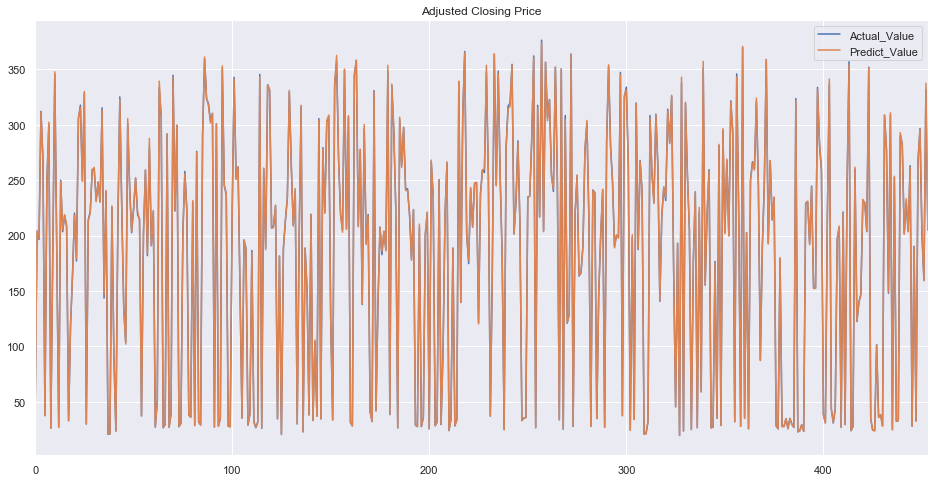

In [25]:
# Plotting the Real and Predict values
y_pred_test = clf_1.predict(X_test)
df_plot = pd.DataFrame({'Actual_Value': y_test.flatten(), 'Predict_Value': y_pred_test.flatten()})
df_plot.plot(figsize=(16,8), title='Adjusted Closing Price', grid=True)